# Class Attention Image Transformers with LayerScale

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2022/09/19<br>
**Last modified:** 2022/09/25<br>
**Description:** Implementing an image transformer equipped with Class Attention and LayerScale.

## Introduction

In this tutorial, we implement the CaiT (Class-Attention in Image Transformers)
proposed in [Going deeper with Image Transformers](https://arxiv.org/abs/2103.17239) by
Touvron et al. Depth scaling, i.e. increasing the model depth for obtaining better
performance and generalization has been quite successful for convolutional neural
networks ([Tan et al.](https://arxiv.org/abs/1905.11946),
[Dollár et al.](https://arxiv.org/abs/2103.06877), for example). But applying
the same model scaling principles to
Vision Transformers ([Dosovitskiy et al.](https://arxiv.org/abs/2010.11929)) doesn't
translate equally well -- their performance gets saturated quickly with depth scaling.
Note that one assumption here is that the underlying pre-training dataset is
always kept fixed when performing model scaling.

In the CaiT paper, the authors investigate this phenomenon and propose modifications to
the vanilla ViT (Vision Transformers) architecture to mitigate this problem.

The tutorial is structured like so:

* Implementation of the individual blocks of CaiT
* Collating all the blocks to create the CaiT model
* Loading a pre-trained CaiT model
* Obtaining prediction results
* Visualization of the different attention layers of CaiT

The readers are assumed to be familiar with Vision Transformers already. Here is
an implementation of Vision Transformers in Keras:
[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

## Imports

In [1]:
import io
import typing
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-06-15 20:01:33.390457: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-15 20:01:33.461720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 20:01:35.759975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## The LayerScale layer

We begin by implementing a **LayerScale** layer which is one of the two modifications
proposed in the CaiT paper.

When increasing the depth of the ViT models, they meet with optimization instability and
eventually don't converge. The residual connections within each Transformer block
introduce information bottleneck. When there is an increased amount of depth, this
bottleneck can quickly explode and deviate the optimization pathway for the underlying
model.

The following equations denote where residual connections are added within a Transformer
block:

<div align="center">
    <img src="https://i.ibb.co/jWV5bFb/image.png"/>
</div>

where, **SA** stands for self-attention, **FFN** stands for feed-forward network, and
**eta** denotes the LayerNorm operator ([Ba et al.](https://arxiv.org/abs/1607.06450)).

LayerScale is formally implemented like so:

<div align="center">
    <img src="https://i.ibb.co/VYDWNn9/image.png"/>
</div>

where, the lambdas are learnable parameters and are initialized with a very small value
({0.1, 1e-5, 1e-6}). **diag** represents a diagonal matrix.

Intuitively, LayerScale helps control the contribution of the residual branches. The
learnable parameters of LayerScale are initialized to a small value to let the branches
act like identity functions and then let them figure out the degrees of interactions
during the training. The diagonal matrix additionally helps control the contributions
of the individual dimensions of the residual inputs as it is applied on a per-channel
basis.

The practical implementation of LayerScale is simpler than it might sound.

In [2]:

class LayerScale(layers.Layer):
    """LayerScale as introduced in CaiT: https://arxiv.org/abs/2103.17239.

    Args:
        init_values (float): value to initialize the diagonal matrix of LayerScale.
        projection_dim (int): projection dimension used in LayerScale.
    """

    def __init__(self, init_values: float, projection_dim: int, **kwargs):
        super().__init__(**kwargs)
        self.gamma = tf.Variable(init_values * tf.ones((projection_dim,)))

    def call(self, x, training=False):
        return x * self.gamma


## Stochastic depth layer

Since its introduction ([Huang et al.](https://arxiv.org/abs/1603.09382)), Stochastic
Depth has become a favorite component in almost all modern neural network architectures.
CaiT is no exception. Discussing Stochastic Depth is out of scope for this notebook. You
can refer to [this resource](https://paperswithcode.com/method/stochastic-depth) in case
you need a refresher.

In [3]:

class StochasticDepth(layers.Layer):
    """Stochastic Depth layer (https://arxiv.org/abs/1603.09382).

    Reference:
        https://github.com/rwightman/pytorch-image-models
    """

    def __init__(self, drop_prob: float, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=False):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


## Class attention

The vanilla ViT uses self-attention (SA) layers for modelling how the image patches and
the _learnable_ CLS token interact with each other. The CaiT authors propose to decouple
the attention layers responsible for attending to the image patches and the CLS tokens.

When using ViTs for any discriminative tasks (classification, for example), we usually
take the representations belonging to the CLS token and then pass them to the
task-specific heads. This is as opposed to using something like global average pooling as
is typically done in convolutional neural networks.

The interactions between the CLS token and other image patches are processed uniformly
through self-attention layers. As the CaiT authors point out, this setup has got an
entangled effect. On one hand, the self-attention layers are responsible for modelling
the image patches. On the other hand, they're also responsible for summarizing the
modelled information via the CLS token so that it's useful for the learning objective.

To help disentangle these two things, the authors propose to:

* Introduce the CLS token at a later stage in the network.
* Model the interaction between the CLS token and the representations related to the
image patches through a separate set of attention layers. The authors call this **Class
Attention** (CA).

The figure below (taken from the original paper) depicts this idea:

<div align="center">
    <img src="https://i.imgur.com/cxeooHr.png"/ width=350>
</div>

This is achieved by treating the CLS token embeddings as the queries in the CA layers.
CLS token embeddings and the image patch embeddings are fed as keys as well values.

**Note** that "embeddings" and "representations" have been used interchangeably here.

In [4]:

class ClassAttention(layers.Layer):
    """Class attention as proposed in CaiT: https://arxiv.org/abs/2103.17239.

    Args:
        projection_dim (int): projection dimension for the query, key, and value
            of attention.
        num_heads (int): number of attention heads.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
    """

    def __init__(
        self, projection_dim: int, num_heads: int, dropout_rate: float, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_heads = num_heads

        head_dim = projection_dim // num_heads
        self.scale = head_dim**-0.5

        self.q = layers.Dense(projection_dim)
        self.k = layers.Dense(projection_dim)
        self.v = layers.Dense(projection_dim)
        self.attn_drop = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(projection_dim)
        self.proj_drop = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        batch_size, num_patches, num_channels = (
            tf.shape(x)[0],
            tf.shape(x)[1],
            tf.shape(x)[2],
        )

        # Query projection. `cls_token` embeddings are queries.
        q = tf.expand_dims(self.q(x[:, 0]), axis=1)
        q = tf.reshape(
            q, (batch_size, 1, self.num_heads, num_channels // self.num_heads)
        )  # Shape: (batch_size, 1, num_heads, dimension_per_head)
        q = tf.transpose(q, perm=[0, 2, 1, 3])
        scale = tf.cast(self.scale, dtype=q.dtype)
        q = q * scale

        # Key projection. Patch embeddings as well the cls embedding are used as keys.
        k = self.k(x)
        k = tf.reshape(
            k, (batch_size, num_patches, self.num_heads, num_channels // self.num_heads)
        )  # Shape: (batch_size, num_tokens, num_heads, dimension_per_head)
        k = tf.transpose(k, perm=[0, 2, 1, 3])

        # Value projection. Patch embeddings as well the cls embedding are used as values.
        v = self.v(x)
        v = tf.reshape(
            v, (batch_size, num_patches, self.num_heads, num_channels // self.num_heads)
        )
        v = tf.transpose(v, perm=[0, 2, 1, 3])

        # Calculate attention scores between cls_token embedding and patch embeddings.
        attn = tf.matmul(q, k, transpose_b=True)
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn, training)

        x_cls = tf.matmul(attn, v)
        x_cls = tf.transpose(x_cls, perm=[0, 2, 1, 3])
        x_cls = tf.reshape(x_cls, (batch_size, 1, num_channels))
        x_cls = self.proj(x_cls)
        x_cls = self.proj_drop(x_cls, training)

        return x_cls, attn


## Talking Head Attention

The CaiT authors use the Talking Head attention
([Shazeer et al.](https://arxiv.org/abs/2003.02436))
instead of the vanilla scaled dot-product multi-head attention used in
the original Transformer paper
([Vaswani et al.](https://papers.nips.cc/paper/7181-attention-is-all-you-need)).
They introduce two linear projections before and after the softmax
operations for obtaining better results.

For a more rigorous treatment of the Talking Head attention and the vanilla attention
mechanisms, please refer to their respective papers (linked above).

In [5]:

class TalkingHeadAttention(layers.Layer):
    """Talking-head attention as proposed in CaiT: https://arxiv.org/abs/2003.02436.

    Args:
        projection_dim (int): projection dimension for the query, key, and value
            of attention.
        num_heads (int): number of attention heads.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
    """

    def __init__(
        self, projection_dim: int, num_heads: int, dropout_rate: float, **kwargs
    ):
        super().__init__(**kwargs)

        self.num_heads = num_heads

        head_dim = projection_dim // self.num_heads

        self.scale = head_dim**-0.5

        self.qkv = layers.Dense(projection_dim * 3)
        self.attn_drop = layers.Dropout(dropout_rate)

        self.proj = layers.Dense(projection_dim)

        self.proj_l = layers.Dense(self.num_heads)
        self.proj_w = layers.Dense(self.num_heads)

        self.proj_drop = layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        B, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]

        # Project the inputs all at once.
        qkv = self.qkv(x)

        # Reshape the projected output so that they're segregated in terms of
        # query, key, and value projections.
        qkv = tf.reshape(qkv, (B, N, 3, self.num_heads, C // self.num_heads))

        # Transpose so that the `num_heads` becomes the leading dimensions.
        # Helps to better segregate the representation sub-spaces.
        qkv = tf.transpose(qkv, perm=[2, 0, 3, 1, 4])
        scale = tf.cast(self.scale, dtype=qkv.dtype)
        q, k, v = qkv[0] * scale, qkv[1], qkv[2]

        # Obtain the raw attention scores.
        attn = tf.matmul(q, tf.transpose(k, perm=[0, 1, 3, 2]))

        # Linear projection of the similarities between the query and key projections.
        attn = self.proj_l(tf.transpose(attn, perm=[0, 2, 3, 1]))

        # Normalize the attention scores.
        attn = tf.transpose(attn, perm=[0, 3, 1, 2])
        attn = tf.nn.softmax(attn, axis=-1)

        # Linear projection on the softmaxed scores.
        attn = self.proj_w(tf.transpose(attn, perm=[0, 2, 3, 1]))
        attn = tf.transpose(attn, perm=[0, 3, 1, 2])
        attn = self.attn_drop(attn, training)

        # Final set of projections as done in the vanilla attention mechanism.
        x = tf.matmul(attn, v)
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        x = tf.reshape(x, (B, N, C))

        x = self.proj(x)
        x = self.proj_drop(x, training)

        return x, attn


## Feed-forward Network

Next, we implement the feed-forward network which is one of the components within a
Transformer block.

In [6]:

def mlp(x, dropout_rate: float, hidden_units: typing.List[int]):
    """FFN for a Transformer block."""
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
            bias_initializer=keras.initializers.RandomNormal(stddev=1e-6),
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Other blocks

In the next two cells, we implement the remaining blocks as standalone functions:

* `LayerScaleBlockClassAttention()` which returns a `keras.Model`. It is a Transformer block
equipped with Class Attention, LayerScale, and Stochastic Depth. It operates on the CLS
embeddings and the image patch embeddings.
* `LayerScaleBlock()` which returns a `keras.model`. It is also a Transformer block that
operates only on the embeddings of the image patches. It is equipped with LayerScale and
Stochastic Depth.

In [7]:

def LayerScaleBlockClassAttention(
    projection_dim: int,
    num_heads: int,
    layer_norm_eps: float,
    init_values: float,
    mlp_units: typing.List[int],
    dropout_rate: float,
    sd_prob: float,
    name: str,
):
    """Pre-norm transformer block meant to be applied to the embeddings of the
    cls token and the embeddings of image patches.

    Includes LayerScale and Stochastic Depth.

    Args:
        projection_dim (int): projection dimension to be used in the
            Transformer blocks and patch projection layer.
        num_heads (int): number of attention heads.
        layer_norm_eps (float): epsilon to be used for Layer Normalization.
        init_values (float): initial value for the diagonal matrix used in LayerScale.
        mlp_units (List[int]): dimensions of the feed-forward network used in
            the Transformer blocks.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
        sd_prob (float): stochastic depth rate.
        name (str): a name identifier for the block.

    Returns:
        A keras.Model instance.
    """
    x = keras.Input((None, projection_dim))
    x_cls = keras.Input((None, projection_dim))
    inputs = keras.layers.Concatenate(axis=1)([x_cls, x])

    # Class attention (CA).
    x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(inputs)
    attn_output, attn_scores = ClassAttention(projection_dim, num_heads, dropout_rate)(
        x1
    )
    attn_output = (
        LayerScale(init_values, projection_dim)(attn_output)
        if init_values
        else attn_output
    )
    attn_output = StochasticDepth(sd_prob)(attn_output) if sd_prob else attn_output
    x2 = keras.layers.Add()([x_cls, attn_output])

    # FFN.
    x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
    x4 = mlp(x3, hidden_units=mlp_units, dropout_rate=dropout_rate)
    x4 = LayerScale(init_values, projection_dim)(x4) if init_values else x4
    x4 = StochasticDepth(sd_prob)(x4) if sd_prob else x4
    outputs = keras.layers.Add()([x2, x4])

    return keras.Model([x, x_cls], [outputs, attn_scores], name=name)


def LayerScaleBlock(
    projection_dim: int,
    num_heads: int,
    layer_norm_eps: float,
    init_values: float,
    mlp_units: typing.List[int],
    dropout_rate: float,
    sd_prob: float,
    name: str,
):
    """Pre-norm transformer block meant to be applied to the embeddings of the
    image patches.

    Includes LayerScale and Stochastic Depth.

        Args:
            projection_dim (int): projection dimension to be used in the
                Transformer blocks and patch projection layer.
            num_heads (int): number of attention heads.
            layer_norm_eps (float): epsilon to be used for Layer Normalization.
            init_values (float): initial value for the diagonal matrix used in LayerScale.
            mlp_units (List[int]): dimensions of the feed-forward network used in
                the Transformer blocks.
            dropout_rate (float): dropout rate to be used for dropout in the attention
                scores as well as the final projected outputs.
            sd_prob (float): stochastic depth rate.
            name (str): a name identifier for the block.

    Returns:
        A keras.Model instance.
    """
    encoded_patches = keras.Input((None, projection_dim))

    # Self-attention.
    x1 = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    attn_output, attn_scores = TalkingHeadAttention(
        projection_dim, num_heads, dropout_rate
    )(x1)
    attn_output = (
        LayerScale(init_values, projection_dim)(attn_output)
        if init_values
        else attn_output
    )
    attn_output = StochasticDepth(sd_prob)(attn_output) if sd_prob else attn_output
    x2 = layers.Add()([encoded_patches, attn_output])

    # FFN.
    x3 = layers.LayerNormalization(epsilon=layer_norm_eps)(x2)
    x4 = mlp(x3, hidden_units=mlp_units, dropout_rate=dropout_rate)
    x4 = LayerScale(init_values, projection_dim)(x4) if init_values else x4
    x4 = StochasticDepth(sd_prob)(x4) if sd_prob else x4
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, [outputs, attn_scores], name=name)


Given all these blocks, we are now ready to collate them into the final CaiT model.

## Putting the pieces together: The CaiT model

In [8]:

class CaiT(keras.Model):
    """CaiT model.

    Args:
        projection_dim (int): projection dimension to be used in the
            Transformer blocks and patch projection layer.
        patch_size (int): patch size of the input images.
        num_patches (int): number of patches after extracting the image patches.
        init_values (float): initial value for the diagonal matrix used in LayerScale.
        mlp_units: (List[int]): dimensions of the feed-forward network used in
            the Transformer blocks.
        sa_ffn_layers (int): number of self-attention Transformer blocks.
        ca_ffn_layers (int): number of class-attention Transformer blocks.
        num_heads (int): number of attention heads.
        layer_norm_eps (float): epsilon to be used for Layer Normalization.
        dropout_rate (float): dropout rate to be used for dropout in the attention
            scores as well as the final projected outputs.
        sd_prob (float): stochastic depth rate.
        global_pool (str): denotes how to pool the representations coming out of
            the final Transformer block.
        pre_logits (bool): if set to True then don't add a classification head.
        num_classes (int): number of classes to construct the final classification
            layer with.
    """

    def __init__(
        self,
        projection_dim: int,
        patch_size: int,
        num_patches: int,
        init_values: float,
        mlp_units: typing.List[int],
        sa_ffn_layers: int,
        ca_ffn_layers: int,
        num_heads: int,
        layer_norm_eps: float,
        dropout_rate: float,
        sd_prob: float,
        global_pool: str,
        pre_logits: bool,
        num_classes: int,
        **kwargs,
    ):
        if global_pool not in ["token", "avg"]:
            raise ValueError(
                'Invalid value received for `global_pool`, should be either `"token"` or `"avg"`.'
            )

        super().__init__(**kwargs)

        # Responsible for patchifying the input images and the linearly projecting them.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=projection_dim,
                    kernel_size=(patch_size, patch_size),
                    strides=(patch_size, patch_size),
                    padding="VALID",
                    name="conv_projection",
                    kernel_initializer="lecun_normal",
                ),
                layers.Reshape(
                    target_shape=(-1, projection_dim),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # CLS token and the positional embeddings.
        self.cls_token = tf.Variable(tf.zeros((1, 1, projection_dim)))
        self.pos_embed = tf.Variable(tf.zeros((1, num_patches, projection_dim)))

        # Projection dropout.
        self.pos_drop = layers.Dropout(dropout_rate, name="projection_dropout")

        # Stochastic depth schedule.
        dpr = [sd_prob for _ in range(sa_ffn_layers)]

        # Self-attention (SA) Transformer blocks operating only on the image patch
        # embeddings.
        self.blocks = [
            LayerScaleBlock(
                projection_dim=projection_dim,
                num_heads=num_heads,
                layer_norm_eps=layer_norm_eps,
                init_values=init_values,
                mlp_units=mlp_units,
                dropout_rate=dropout_rate,
                sd_prob=dpr[i],
                name=f"sa_ffn_block_{i}",
            )
            for i in range(sa_ffn_layers)
        ]

        # Class Attention (CA) Transformer blocks operating on the CLS token and image patch
        # embeddings.
        self.blocks_token_only = [
            LayerScaleBlockClassAttention(
                projection_dim=projection_dim,
                num_heads=num_heads,
                layer_norm_eps=layer_norm_eps,
                init_values=init_values,
                mlp_units=mlp_units,
                dropout_rate=dropout_rate,
                name=f"ca_ffn_block_{i}",
                sd_prob=0.0,  # No Stochastic Depth in the class attention layers.
            )
            for i in range(ca_ffn_layers)
        ]

        # Pre-classification layer normalization.
        self.norm = layers.LayerNormalization(epsilon=layer_norm_eps, name="head_norm")

        # Representation pooling for classification head.
        self.global_pool = global_pool

        # Classification head.
        self.pre_logits = pre_logits
        self.num_classes = num_classes
        if not pre_logits:
            self.head = layers.Dense(num_classes, name="classification_head")

    def call(self, x, training=False):
        # Notice how CLS token is not added here.
        x = self.projection(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # SA+FFN layers.
        sa_ffn_attn = {}
        for blk in self.blocks:
            x, attn_scores = blk(x)
            sa_ffn_attn[f"{blk.name}_att"] = attn_scores

        # CA+FFN layers.
        ca_ffn_attn = {}
        cls_tokens = tf.tile(self.cls_token, (tf.shape(x)[0], 1, 1))
        for blk in self.blocks_token_only:
            cls_tokens, attn_scores = blk([x, cls_tokens])
            ca_ffn_attn[f"{blk.name}_att"] = attn_scores

        x = tf.concat([cls_tokens, x], axis=1)
        x = self.norm(x)

        # Always return the attention scores from the SA+FFN and CA+FFN layers
        # for convenience.
        if self.global_pool:
            x = (
                tf.reduce_mean(x[:, 1:], axis=1)
                if self.global_pool == "avg"
                else x[:, 0]
            )
        return (
            (x, sa_ffn_attn, ca_ffn_attn)
            if self.pre_logits
            else (self.head(x), sa_ffn_attn, ca_ffn_attn)
        )


Having the SA and CA layers segregated this way helps the model to focus on underlying
objectives more concretely:

* model dependencies in between the image patches
* summarize the information from the image patches in a CLS token that can be used for
the task at hand

Now that we have defined the CaiT model, it's time to test it. We will start by defining
a model configuration that will be passed to our `CaiT` class for initialization.

## Defining Model Configuration

In [9]:

def get_config(
    image_size: int = 224,
    patch_size: int = 16,
    projection_dim: int = 192,
    sa_ffn_layers: int = 24,
    ca_ffn_layers: int = 2,
    num_heads: int = 4,
    mlp_ratio: int = 4,
    layer_norm_eps=1e-6,
    init_values: float = 1e-5,
    dropout_rate: float = 0.0,
    sd_prob: float = 0.0,
    global_pool: str = "token",
    pre_logits: bool = False,
    num_classes: int = 1000,
) -> typing.Dict:
    """Default configuration for CaiT models (cait_xxs24_224).

    Reference:
        https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/cait.py
    """
    config = {}

    # Patchification and projection.
    config["patch_size"] = patch_size
    config["num_patches"] = (image_size // patch_size) ** 2

    # LayerScale.
    config["init_values"] = init_values

    # Dropout and Stochastic Depth.
    config["dropout_rate"] = dropout_rate
    config["sd_prob"] = sd_prob

    # Shared across different blocks and layers.
    config["layer_norm_eps"] = layer_norm_eps
    config["projection_dim"] = projection_dim
    config["mlp_units"] = [
        projection_dim * mlp_ratio,
        projection_dim,
    ]

    # Attention layers.
    config["num_heads"] = num_heads
    config["sa_ffn_layers"] = sa_ffn_layers
    config["ca_ffn_layers"] = ca_ffn_layers

    # Representation pooling and task specific parameters.
    config["global_pool"] = global_pool
    config["pre_logits"] = pre_logits
    config["num_classes"] = num_classes

    return config


Most of the configuration variables should sound familiar to you if you already know the
ViT architecture. Point of focus is given to `sa_ffn_layers` and `ca_ffn_layers` that
control the number of SA-Transformer blocks and CA-Transformer blocks. You can easily
amend this `get_config()` method to instantiate a CaiT model for your own dataset.

## Model Instantiation

In [10]:
image_size = 224
num_channels = 3
batch_size = 2

config = get_config()
cait_xxs24_224 = CaiT(**config)

dummy_inputs = tf.ones((batch_size, image_size, image_size, num_channels))
_ = cait_xxs24_224(dummy_inputs)

2023-06-15 20:01:38.020423: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-06-15 20:01:38.020476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: zlabshwa01
2023-06-15 20:01:38.020488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: zlabshwa01
2023-06-15 20:01:38.020683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-06-15 20:01:38.020722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 515.105.1
2023-06-15 20:01:38.020733: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 515.105.1 does not match DSO version 530.30.2 -- cannot find working devices in this configuration


We can successfully perform inference with the model. But what about implementation
correctness? There are many ways to verify it:

* Obtain the performance of the model (given it's been populated with the pre-trained
parameters) on the ImageNet-1k validation set (as the pretraining dataset was
ImageNet-1k).
* Fine-tune the model on a different dataset.

In order to verify that, we will load another instance of the same model that has been
already populated with the pre-trained parameters. Please refer to
[this repository](https://github.com/sayakpaul/cait-tf)
(developed by the author of this notebook) for more details.
Additionally, the repository provides code to verify model performance on the
[ImageNet-1k validation set](https://github.com/sayakpaul/cait-tf/tree/main/i1k_eval)
as well as
[fine-tuning](https://github.com/sayakpaul/cait-tf/blob/main/notebooks/finetune.ipynb).

## Load a pretrained model

In [11]:
model_gcs_path = "gs://tfhub-modules/sayakpaul/cait_xxs24_224/1/uncompressed"
pretrained_model = keras.models.load_model(model_gcs_path)

2023-06-15 20:01:44.501503: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
2023-06-15 20:02:31.222128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,?,192]
	 [[{{node x}}]]
2023-06-15 20:02:31.230190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this messag

2023-06-15 20:02:32.468967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,?,192]
	 [[{{node x}}]]
2023-06-15 20:02:32.527553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?,192]
	 [[{{node Placeholder}}]]
2023-06-15 20:02:32.834505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,?,192]
	 [[{{node x}}]]
2023-06-15 20:02:32.

2023-06-15 20:02:34.004164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?,192]
	 [[{{node Placeholder}}]]
2023-06-15 20:02:34.060184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,?,192]
	 [[{{node x}}]]
2023-06-15 20:02:34.067680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,?,192]
	 [[{{node Placeholder}}]]


## Inference utilities

In the next couple of cells, we develop preprocessing utilities needed to run inference
with the pretrained model.

In [12]:
# The preprocessing transformations include center cropping, and normalizing
# the pixel values with the ImageNet-1k training stats (mean and standard deviation).
crop_layer = keras.layers.CenterCrop(image_size, image_size)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)


def preprocess_image(image, size=image_size):
    image = np.array(image)
    image_resized = tf.expand_dims(image, 0)
    resize_size = int((256 / image_size) * size)
    image_resized = tf.image.resize(
        image_resized, (resize_size, resize_size), method="bicubic"
    )
    image_resized = crop_layer(image_resized)
    return norm_layer(image_resized).numpy()


def load_image_from_url(url):
    image_bytes = io.BytesIO(urlopen(url).read())
    image = PIL.Image.open(image_bytes)
    preprocessed_image = preprocess_image(image)
    return image, preprocessed_image


Now, we retrieve the ImageNet-1k labels and load them as the model we're
loading was pretrained on the ImageNet-1k dataset.

In [13]:
# ImageNet-1k class labels.
imagenet_labels = (
    "https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)
label_path = keras.utils.get_file(origin=imagenet_labels)

with open(label_path, "r") as f:
    lines = f.readlines()
imagenet_labels = [line.rstrip() for line in lines]

## Load an Image

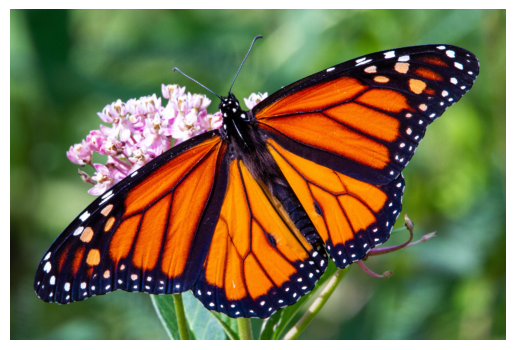

In [14]:
img_url = "https://i.imgur.com/ErgfLTn.jpg"
image, preprocessed_image = load_image_from_url(img_url)

# https://unsplash.com/photos/Ho93gVTRWW8
plt.imshow(image)
plt.axis("off")
plt.show()

## Obtain Predictions

In [15]:
logits, sa_atn_score_dict, ca_atn_score_dict = pretrained_model.predict(
    preprocessed_image
)
predicted_label = imagenet_labels[int(np.argmax(logits))]
print(predicted_label)

1/1 [==============================] - 4s 4s/step
monarch, monarch_butterfly, milkweed_butterfly, Danaus_plexippus


Now that we have obtained the predictions (which appear to be as expected), we can
further extend our investigation. Following the CaiT authors, we can investigate the
attention scores from the attention layers. This helps us to get deeper insights into the
modifications introduced in the CaiT paper.

## Visualizing the Attention Layers

We start by inspecting the shape of the attention weights returned by a Class Attention
layer.

In [16]:
# (batch_size, nb_attention_heads, num_cls_token, seq_length)
print("Shape of the attention scores from a class attention block:")
print(ca_atn_score_dict["ca_ffn_block_0_att"].shape)

Shape of the attention scores from a class attention block:
(1, 4, 1, 197)


The shape denotes we have got attention weights for each of the individual attention
heads. They quantify the information about how the CLS token is related to itself and the
rest of the image patches.

Next, we write a utility to:

* Visualize what the individual attention heads in the Class Attention layers are
focusing on. This helps us to get an idea of how the _spatial-class relationship_ is
induced in the CaiT model.
* Obtain a saliency map from the first Class Attention layer that helps to understand how
CA layer aggregates information from the region(s) of interest in the images.

This utility is referred from Figures 6 and 7 of the original
[CaiT paper](https://arxiv.org/abs/2103.17239). This is also a part of
[this notebook](https://github.com/sayakpaul/cait-tf/blob/main/notebooks/classification.ipynb)
(developed by the author of this tutorial).

In [17]:
# Reference:
# https://github.com/facebookresearch/dino/blob/main/visualize_attention.py

patch_size = 16


def get_cls_attention_map(
    attn_score_dict=ca_atn_score_dict,
    block_key="ca_ffn_block_0_att",
    return_saliency=False,
) -> np.ndarray:
    """
    Returns attention scores from a particular attention block.

    Args:
        attn_score_dict: dict where the attention layer names are keys and corresponding
            attention scores are values.
        block_key: name of the attention block which we want to visualize.
        return_saliency: a boolean flag if set to True also returns the salient
            representations of the attention block.
    """
    w_featmap = preprocessed_image.shape[2] // patch_size
    h_featmap = preprocessed_image.shape[1] // patch_size

    attention_scores = attn_score_dict[block_key]
    nh = attention_scores.shape[1]  # Number of attention heads.

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, 1:].reshape(nh, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(nh, w_featmap, h_featmap)

    if not return_saliency:
        attentions = attentions.transpose((1, 2, 0))

    else:
        attentions = np.mean(attentions, axis=0)
        attentions = (attentions - attentions.min()) / (
            attentions.max() - attentions.min()
        )
        attentions = np.expand_dims(attentions, -1)

    # Resize the attention patches to 224x224 (224: 14x16)
    attentions = tf.image.resize(
        attentions,
        size=(h_featmap * patch_size, w_featmap * patch_size),
        method="bicubic",
    )

    return attentions


In the first CA layer, we notice that the model is focusing solely on the region of
interest.

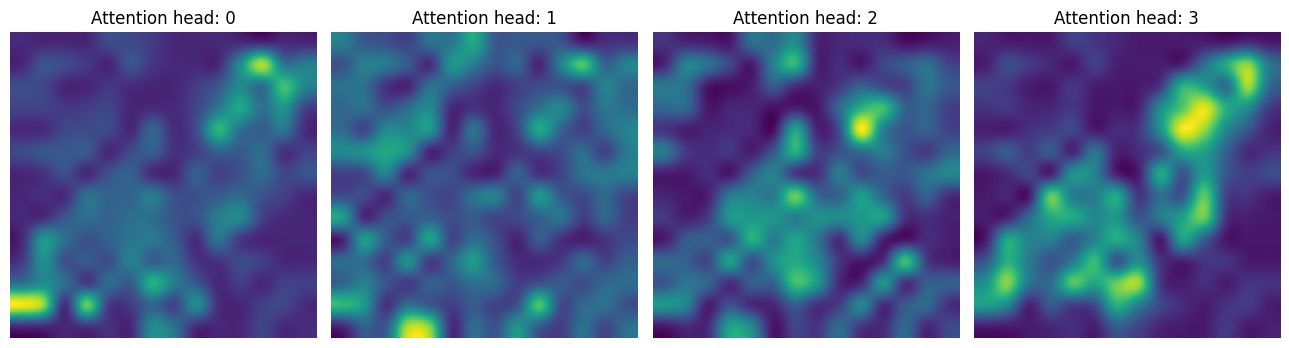

In [18]:
attentions_ca_block_0 = get_cls_attention_map()


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(attentions_ca_block_0.shape[-1]):
    if img_count < attentions_ca_block_0.shape[-1]:
        axes[i].imshow(attentions_ca_block_0[:, :, img_count])
        axes[i].title.set_text(f"Attention head: {img_count}")
        axes[i].axis("off")
        img_count += 1

fig.tight_layout()
plt.show()

Whereas in the second CA layer, the model is trying to focus more on the context that
contains discriminative signals.

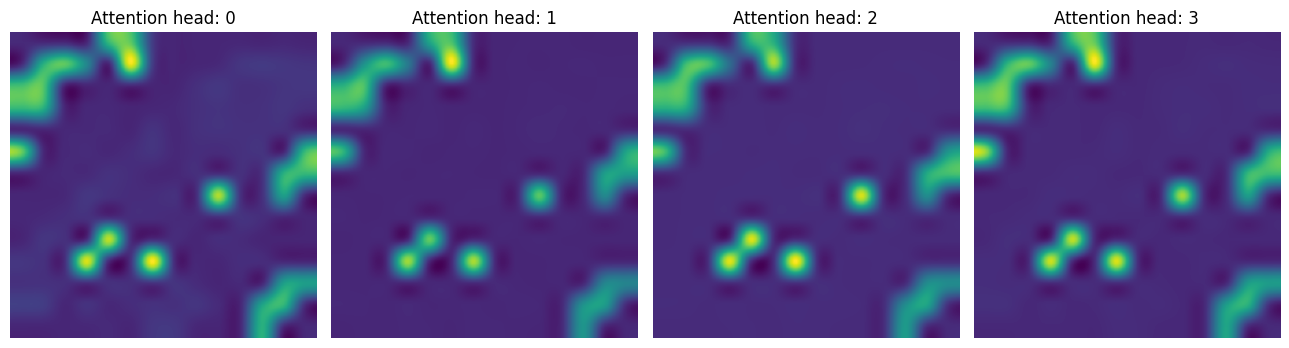

In [19]:
attentions_ca_block_1 = get_cls_attention_map(block_key="ca_ffn_block_1_att")


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(attentions_ca_block_1.shape[-1]):
    if img_count < attentions_ca_block_1.shape[-1]:
        axes[i].imshow(attentions_ca_block_1[:, :, img_count])
        axes[i].title.set_text(f"Attention head: {img_count}")
        axes[i].axis("off")
        img_count += 1

fig.tight_layout()
plt.show()

Finally, we obtain the saliency map for the given image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


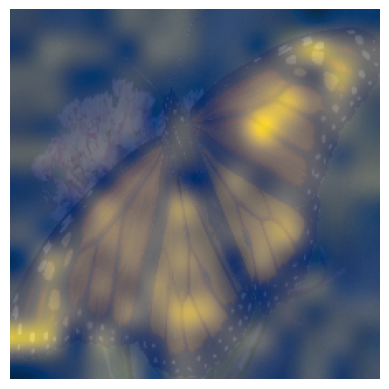

In [20]:
saliency_attention = get_cls_attention_map(return_saliency=True)

image = np.array(image)
image_resized = tf.expand_dims(image, 0)
resize_size = int((256 / 224) * image_size)
image_resized = tf.image.resize(
    image_resized, (resize_size, resize_size), method="bicubic"
)
image_resized = crop_layer(image_resized)

plt.imshow(image_resized.numpy().squeeze().astype("int32"))
plt.imshow(saliency_attention.numpy().squeeze(), cmap="cividis", alpha=0.9)
plt.axis("off")

plt.show()

## Conclusion

In this notebook, we implemented the CaiT model. It shows how to mitigate the issues in
ViTs when trying scale their depth while keeping the pretraining dataset fixed. I hope
the additional visualizations provided in the notebook spark excitement in the community
and people develop interesting methods to probe what models like ViT learn.

## Acknowledgement

Thanks to the ML Developer Programs team at Google providing Google Cloud Platform
support.